In [ ]:
!pip install torch_geometric
!pip install plotly
!pip install --upgrade nbformat
!pip install scikit-learn
!pip install tensorboard
!pip install matplotlib

In [1]:
import os
import numpy as np
import torch
from torch.nn import Linear, MSELoss, BCELoss, ReLU, Dropout, Sequential
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,SAGEConv, MessagePassing, GATv2Conv, LayerNorm
from sklearn.model_selection import train_test_split
from scipy import sparse
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D plotting)
import random

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True

# === Dataset Loader ===
class CarGraphDataset(Dataset):
    def __init__(self, root_dir, indices=None):
        self.root_dir = Path(root_dir)
        all_files = sorted([f for f in self.root_dir.rglob("*.npz") if "_adj" not in f.name])
        self.files = [all_files[i] for i in indices] if indices else all_files
        super().__init__()

    def len(self):
        return len(self.files)

    def get(self, idx):
        feat_file = self.files[idx]
        adj_file = feat_file.with_name(feat_file.name.replace(".npz", "_adj.npz"))
        npz_data = np.load(feat_file)

        x = torch.tensor(npz_data["x"], dtype=torch.float32)
        center_point = torch.tensor(npz_data["center_point"], dtype=torch.float32)
        scale = torch.tensor(npz_data["scale"], dtype=torch.float32)
        cd = torch.tensor(npz_data["cd"], dtype=torch.float32)

        a = sparse.load_npz(adj_file).tocoo()
        edge_index = torch.tensor(np.vstack((a.row, a.col)), dtype=torch.long)

        return Data(x=x, edge_index=edge_index, center_point=center_point, cd_value=cd, scale=scale)


In [4]:
class CdLinearModel(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.model = Sequential(
        Linear(in_features, 4*in_features), ReLU(),
        Linear(4*in_features, 2*in_features), ReLU(),
        Linear(2*in_features, in_features), ReLU(),
        Linear(in_features, out_features)
                )

    def forward(self, x):
        return self.model(x)

In [5]:
#Attention v2
class GraphAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super().__init__()

        self.res_proj = Linear(in_channels, latent_dim)
        self.encoder = Sequential(
            GATv2Conv(in_channels, hidden_channels), ReLU(),
            LayerNorm(hidden_channels),
            GATv2Conv(hidden_channels, 2*hidden_channels //4, heads=4, concat=True,residual=True), ReLU(),
            LayerNorm(2*hidden_channels),
            GATv2Conv(2*hidden_channels, 4*hidden_channels //4, heads=4, concat=True, residual=True), ReLU(),
            LayerNorm(4*hidden_channels)
        )
        self.encoder_lin = Sequential(
            Linear(4*hidden_channels, latent_dim), ReLU(), Dropout(p=0.2))
        self.decoder_lin = Sequential(
            Linear(latent_dim, 2*hidden_channels), ReLU(),
            Linear(2*hidden_channels, hidden_channels), ReLU(),
            Linear(hidden_channels, in_channels)
        )

    def encode(self, x, edge_index, batch=None):
        x_in = x
        for layer in self.encoder:
            if isinstance(layer, MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        z = self.encoder_lin(x)
        z = z + self.res_proj(x_in)
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        z_graph = global_mean_pool(z, batch)
        return z, z_graph

    def decode(self, z):
        return self.decoder_lin(z)

    def forward(self, x, edge_index, batch=None):
        z, z_graph = self.encode(x, edge_index, batch)
        x_hat = self.decode(z)
        return z, x_hat, z_graph


In [6]:

# === Training loop ===
def run_epoch(model,model_cd, loader, optimizer, device, train=True):
    model.train() if train else model.eval()
    total_loss = 0
    total_cd_loss = 0

    loss_weights = {"Node Recon":5.0, "Cd Recon":10.0, "Connect Recon":1.}

    if len(loader) == 0:
        return 0.0

    for batch in loader:
        batch = batch.to(device)
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch

        if train:
            optimizer.zero_grad()

        z, x_hat, z_graph = model(x, edge_index, batch=batch_idx)
        cd_pred = model_cd(z_graph)

        # Reconstruct adjacency (only for existing edges)
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        dot_products = (z_i * z_j).sum(dim=1)
        adj_pred = torch.sigmoid(dot_products).clamp(min=1e-7, max=1 - 1e-7)  # Clamp for stability
        adj_true = torch.ones_like(adj_pred)

        # Losses
        cd_true = batch.cd_value.view(-1, 1)
        loss_x = MSELoss()(x_hat, x)
        loss_cd = MSELoss()(cd_pred, cd_true)
        loss_a = BCELoss()(adj_pred, adj_true)
        loss = loss_weights["Node Recon"]*loss_x + loss_weights["Cd Recon"]*loss_cd + loss_weights["Connect Recon"]*loss_a

        if train:
            loss.backward()
            optimizer.step()

        # if train:
        #     print(f"[Train] Feature Loss: {loss_x.item():.6f} | Adjacency Loss: {loss_a.item():.6f} | Total: {loss.item():.6f}")

        total_loss += loss.item()
        total_cd_loss += loss_cd.item()

    return total_loss / len(loader), total_cd_loss/len(loader)

In [7]:

# === Visualize original vs reconstructed geometry ===
def plot_reconstruction(model, dataset, device, sample_idx=None, max_nodes=100):
    import os
    from pathlib import Path

    model.eval()
    idx = random.choice(range(len(dataset))) if sample_idx is None else sample_idx
    data = dataset[idx].to(device)

    with torch.no_grad():
        z, x_hat, _ = model(
            data.x,
            data.edge_index,
            data.batch if hasattr(data, 'batch') else torch.zeros(data.x.size(0), dtype=torch.long, device=device)
        )

    x_orig = data.x.cpu().numpy()
    x_recon = x_hat.cpu().numpy()

    # Sample up to max_nodes
    num_nodes = x_orig.shape[0]
    sampled_indices = np.random.choice(num_nodes, min(max_nodes, num_nodes), replace=False)

    fig, axes = plt.subplots(1, min(3, x_orig.shape[1]), figsize=(15, 5))
    if min(3, x_orig.shape[1]) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.scatter(range(len(sampled_indices)), x_orig[sampled_indices, i], label="Original", alpha=0.7)
        ax.scatter(range(len(sampled_indices)), x_recon[sampled_indices, i], label="Reconstructed", alpha=0.7, marker='x')
        ax.set_title(f"Feature {i}")
        ax.legend()

    fig.suptitle(f"Scatter Comparison: Sample #{idx}")
    fig.tight_layout()

    save_path = Path("reconstruction_sample.png")
    print("Saving plot to", save_path.resolve())
    plt.savefig(save_path)
    plt.close()

def plot_cd_reconstructions(model, model_cd, test_loader, device):
    model.eval()
    model_cd.eval()

    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
            z, _, z_graph = model(x, edge_index, batch=batch_idx)
            cd_pred = model_cd(z_graph).view(-1).cpu().numpy()
            cd_true = batch.cd_value.view(-1).cpu().numpy()

            all_preds.extend(cd_pred)
            all_trues.extend(cd_true)

    from sklearn.metrics import r2_score

    # Compute metrics
    r2 = r2_score(cd_true, cd_pred)
    rel_errors = np.abs((cd_pred - cd_true) / cd_true)
    max_rel_error = rel_errors.max()
    mean_rel_error = rel_errors.mean()
    
    # Print metrics
    print(f"R² Score: {r2:.4f}")
    print(f"Max Relative Error: {max_rel_error:.6f}")
    print(f"Mean Relative Error: {mean_rel_error:.6f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(all_trues, all_preds, alpha=0.6, label="Predicted vs. True")
    plt.plot([min(all_trues), max(all_trues)],
             [min(all_trues), max(all_trues)],
             linestyle='--', color='red', label="Ideal")
    plt.xlabel("True Cd")
    plt.ylabel("Predicted Cd")
    plt.title(f"Cd Prediction: True vs Predicted\nR²={r2:.4f}, Max Rel Error={max_rel_error:.2%}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:


# === Visualize 2D latent space ===
def plot_latent_space(model, dataset, device):
    model.eval()
    zs = []
    colors = []

    for i, data in enumerate(dataset):
        data = data.to(device)
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)  # if no batch attr
        with torch.no_grad():
            _, _, z_graph = model(data.x, data.edge_index, batch)
        zs.append(z_graph.squeeze(0).cpu().numpy())
        colors.append(i)

    zs = np.array(zs)
    pca = PCA(n_components=2)
    zs_2d = pca.fit_transform(zs)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=colors, cmap='viridis', s=40, edgecolor='k')
    plt.colorbar(scatter, label="Graph index")
    plt.title("2D PCA of Graph-Level Latent Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig("latent_projection.png")
    plt.close()

In [9]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'notebook_connected'

def plot_geometry_comparison_interactive(x_orig_np, x_recon_np, sample_idx=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x_orig_np[:, 0], y=x_orig_np[:, 1], z=x_orig_np[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Original'
    ))

    fig.add_trace(go.Scatter3d(
        x=x_recon_np[:, 0], y=x_recon_np[:, 1], z=x_recon_np[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Reconstructed'
    ))

    fig.update_layout(
        title=f"Interactive Geometry Comparison - Sample #{sample_idx}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()

from IPython.display import clear_output, display
import matplotlib.pyplot as plt

def plot_losses_dual(train_losses, val_losses, cd_train_losses, cd_val_losses):
    from matplotlib.ticker import MaxNLocator
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(len(train_losses))

    # --- Plot total loss ---
    axs[0].plot(epochs, train_losses, label="Train Total Loss", color='blue')
    axs[0].plot(epochs, val_losses, label="Val Total Loss", color='orange')
    axs[0].set_title("Autoencoder Total Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Annotate last values
    if train_losses:
        axs[0].annotate(f"{train_losses[-1]:.6f}",
                        xy=(epochs[-1], train_losses[-1]),
                        xytext=(-40, 0),
                        textcoords="offset points",
                        ha='center', va='center',
                        color='blue')
    if val_losses:
        axs[0].annotate(f"{val_losses[-1]:.6f}",
                        xy=(epochs[-1], val_losses[-1]),
                        xytext=(-40, -15),
                        textcoords="offset points",
                        ha='center', va='center',
                        color='orange')

    # --- Plot Cd loss ---
    axs[1].plot(epochs, cd_train_losses, label="Train Cd Loss", color='green')
    axs[1].plot(epochs, cd_val_losses, label="Val Cd Loss", color='red')
    axs[1].set_title("Cd Prediction Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Annotate last values
    if cd_train_losses:
        axs[1].annotate(f"{cd_train_losses[-1]:.6f}",
                        xy=(epochs[-1], cd_train_losses[-1]),
                        xytext=(-40, 0),
                        textcoords="offset points",
                        ha='center', va='center',
                        color='green')
    if cd_val_losses:
        axs[1].annotate(f"{cd_val_losses[-1]:.6f}",
                        xy=(epochs[-1], cd_val_losses[-1]),
                        xytext=(-40, -15),
                        textcoords="offset points",
                        ha='center', va='center',
                        color='red')

    plt.suptitle("Training Progress with Live Annotations")
    plt.tight_layout()
    display(fig)
    plt.close(fig)

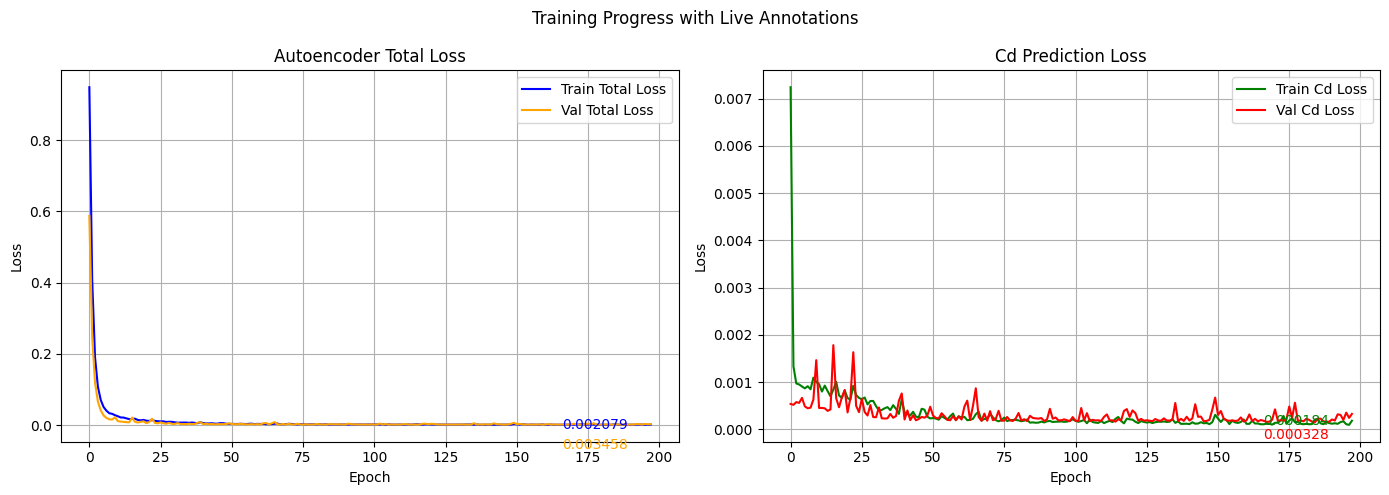

In [ ]:

# === Main execution ===


resume_from_checkpoint = False  # <-- Set this to True to resume from checkpoint
batch_size = 8

path = "Graphs"
all_indices = list(range(len(list(Path(path).rglob("*[!_adj].npz")))))
train_idx, valtest_idx = train_test_split(all_indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(valtest_idx, test_size=0.5, random_state=42)

train_set = CarGraphDataset(path, indices=train_idx)
val_set = CarGraphDataset(path, indices=val_idx)
test_set = CarGraphDataset(path, indices=test_idx)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphAutoEncoder(in_channels=10, hidden_channels=64, latent_dim=512).to(device)
model_cd = CdLinearModel(512, 1).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(model_cd.parameters()), lr=1e-4, weight_decay=1e-4)

writer = SummaryWriter(log_dir="runs/graph_ae")
best_val_loss = float("inf")
start_epoch = 1
os.makedirs("checkpoints", exist_ok=True)

# === Resume from checkpoint if needed ===
if resume_from_checkpoint and Path("checkpoints/best_model.pt").exists():
    print("Loading checkpoint...")
    checkpoint = torch.load("checkpoints/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model_cd.load_state_dict(checkpoint["cd_model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint["best_val_loss"]
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from epoch {start_epoch}, best val loss: {best_val_loss:.6f}")

train_losses = []
val_losses = []
cd_train_losses = []
cd_val_losses = []

for epoch in range(start_epoch, 201):
    train_loss, train_cd_loss = run_epoch(model, model_cd, train_loader, optimizer, device, train=True)
    val_loss, val_cd_loss = run_epoch(model, model_cd, val_loader, optimizer, device, train=False)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    cd_train_losses.append(train_cd_loss)
    cd_val_losses.append(val_cd_loss)

    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    plot_losses_dual(train_losses, val_losses, cd_train_losses, cd_val_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
                "model_state_dict": model.state_dict(),
                "cd_model_state_dict": model_cd.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_val_loss,
                "epoch": epoch
            }, "checkpoints/best_model.pt")



Final Test Loss: 0.002688, Final Cd Test Loss: 0.000203
Saving plot to /workspace/reconstruction_sample.png
R² Score: 0.9159
Max Relative Error: 0.030448
Mean Relative Error: 0.017743


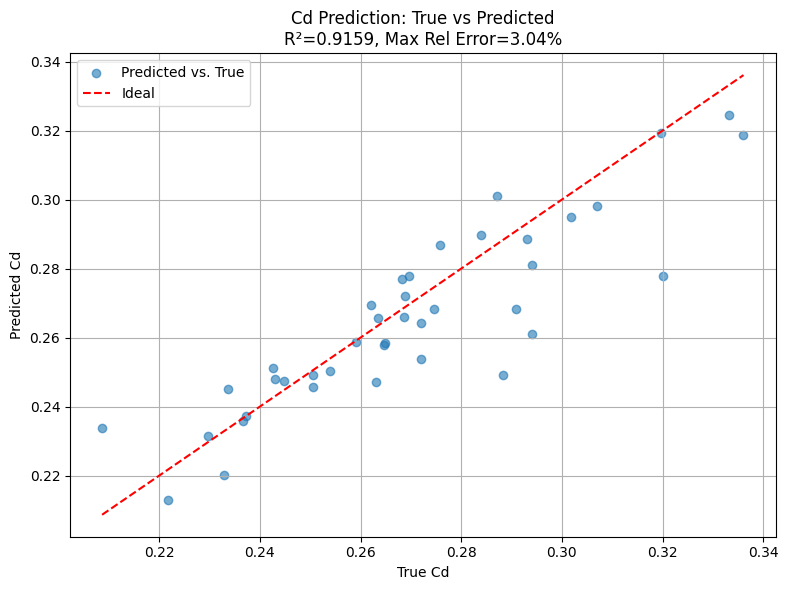

In [18]:

    # === Test ===
    checkpoint = torch.load("checkpoints/best_model.pt", map_location=device)

    # Restore individual components
    model.load_state_dict(checkpoint["model_state_dict"])
    model_cd.load_state_dict(checkpoint["cd_model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  
    test_loss, test_cd_loss = run_epoch(model, model_cd, test_loader, optimizer, device, train=False)
    print(f"Final Test Loss: {test_loss:.6f}, Final Cd Test Loss: {test_cd_loss:.6f}")

    # === Visualizations ===
    #plot_latent_space(model, test_set, device)
    plot_reconstruction(model, test_set, device, sample_idx=8, max_nodes=100)
    plot_cd_reconstructions(model, model_cd, test_loader, device)


In [ ]:
 # === Visualize full geometry ===
sample_idx = 8 # Or None for random
data = test_set[sample_idx].to(device)

model.eval()
with torch.no_grad():
    _, x_hat, _ = model(data.x, data.edge_index)

    x_orig_np = data.x[:, :3].cpu().numpy()
    x_recon_np = x_hat[:, :3].cpu().numpy()

plot_geometry_comparison_interactive(x_orig_np, x_recon_np, sample_idx)